### Дашборд конверсий


url https://data-charts-api.hexlet.app/visits
cols ['datetime', 'user_id', 'email', 'platform', 'registration_type']
    date_group platform  visits  registrations  conversion
0   2023-03-01  android      75             61        81.0
1   2023-03-01      ios      22             18        82.0
2   2023-03-01      web     279              8         3.0
3   2023-03-02  android      67             59        88.0
4   2023-03-02      ios      31             24        77.0
..         ...      ...     ...            ...         ...
546 2023-08-30  android      35             27        77.0
548 2023-08-30      web    1227             34         3.0
550 2023-08-31      ios      50             36        72.0
549 2023-08-31  android      57             42        74.0
551 2023-08-31      web     721             46         6.0

[552 rows x 5 columns]
     date_group platform  visits  registrations                utm_campaign  \
0    2023-03-01  android      75             61  advanced_algorithms_ser

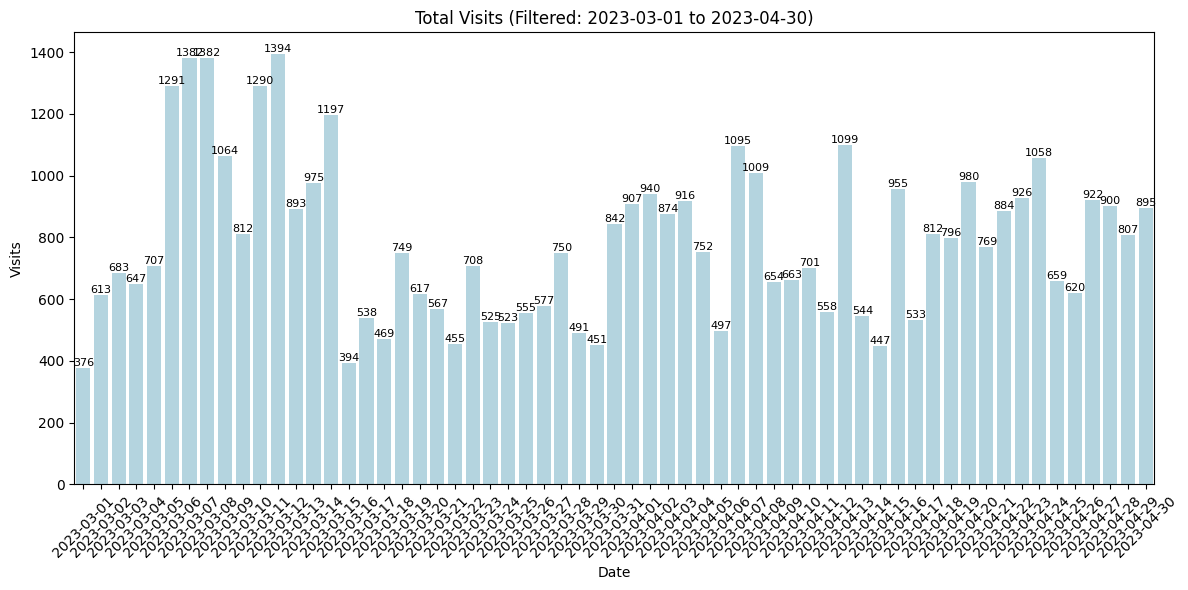

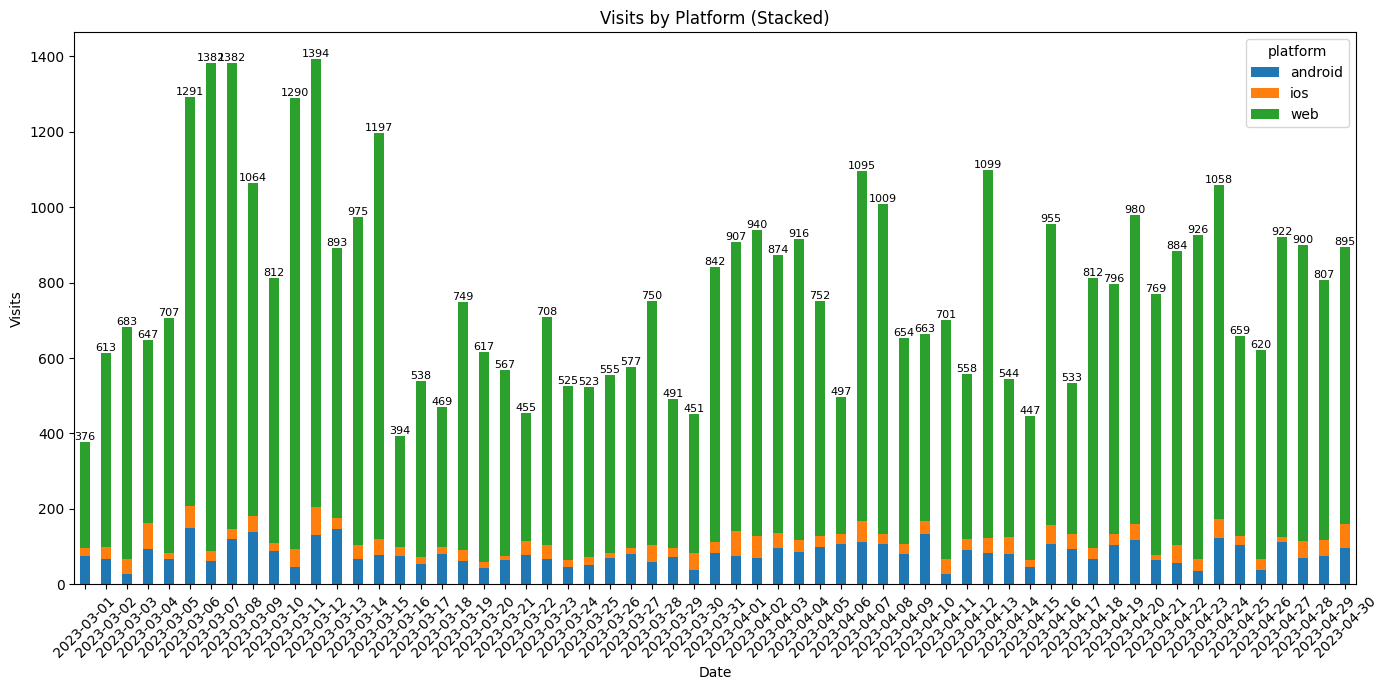

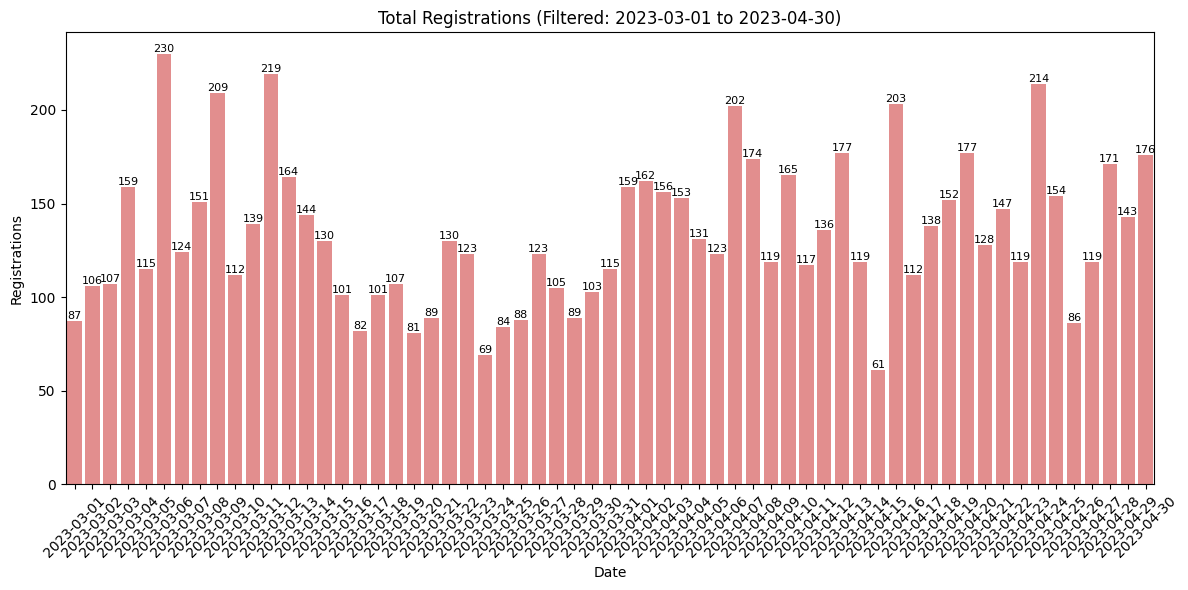

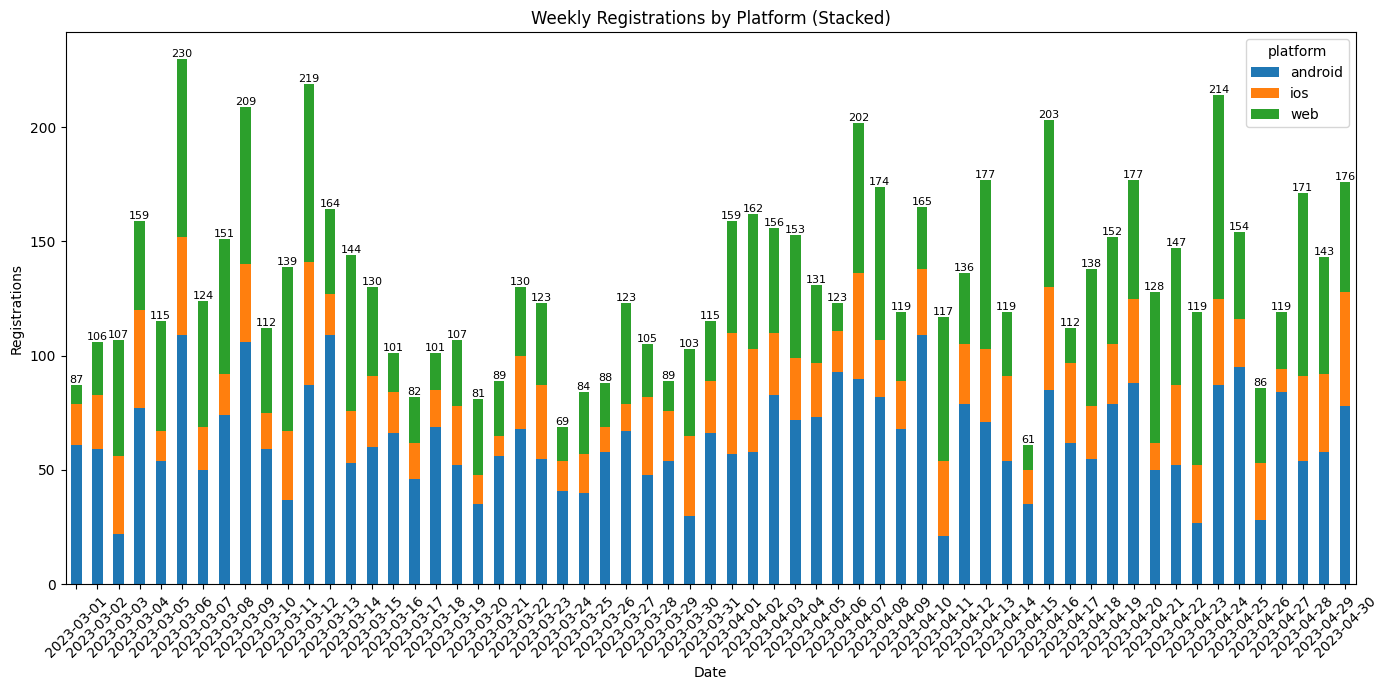

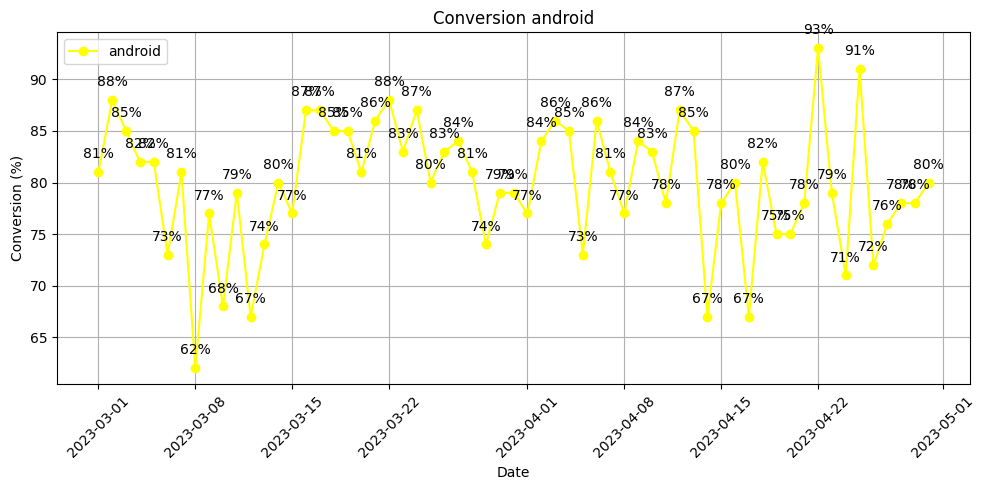

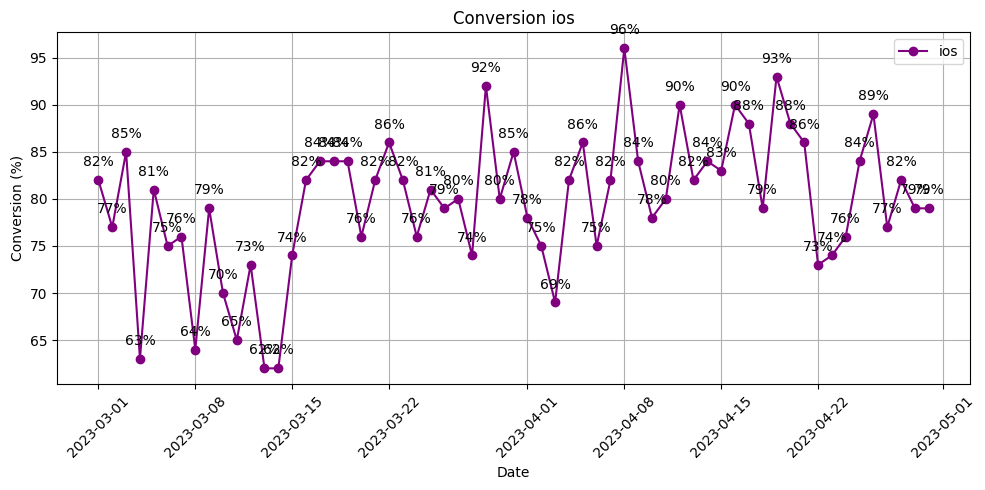

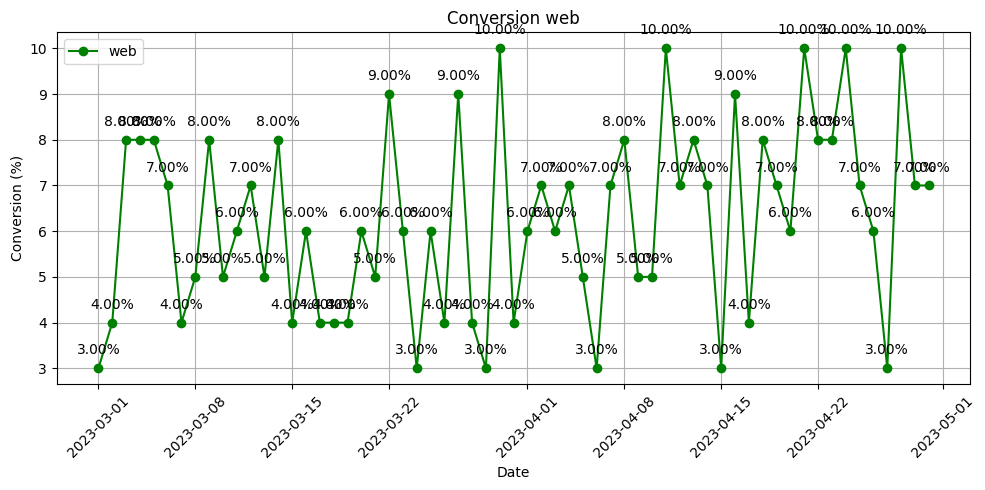

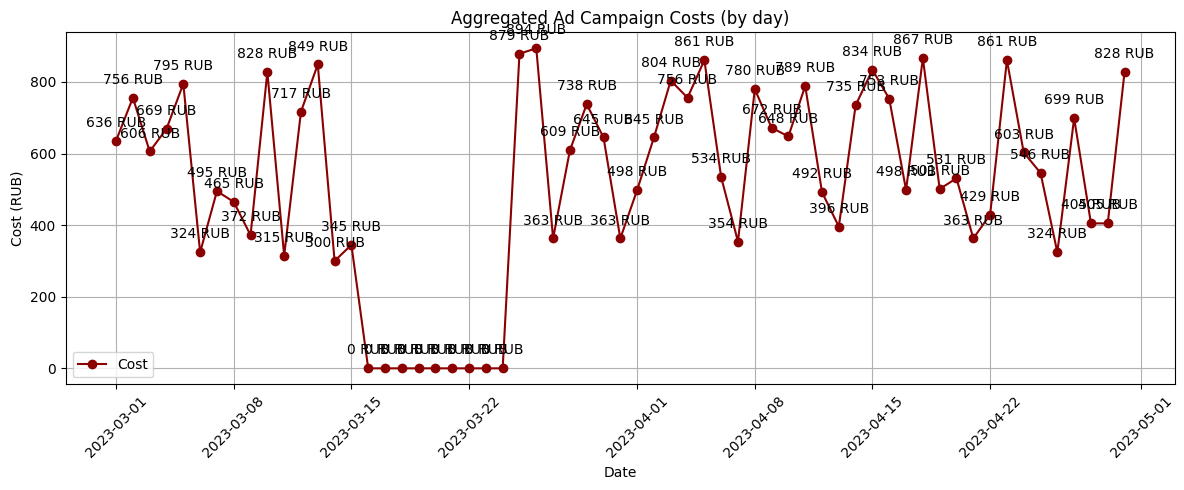

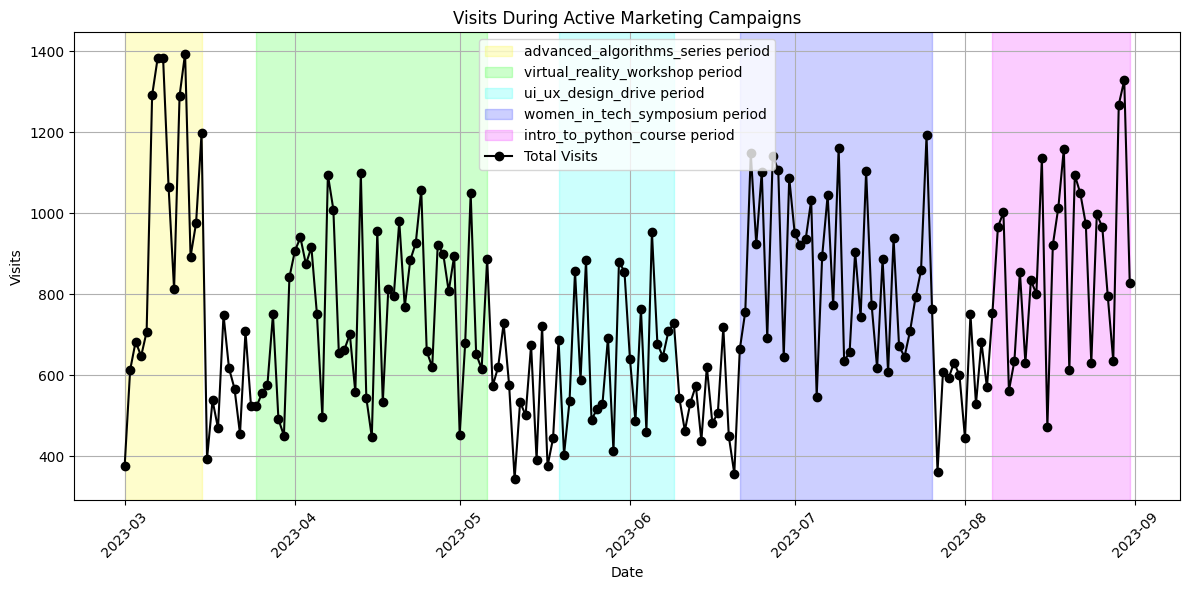

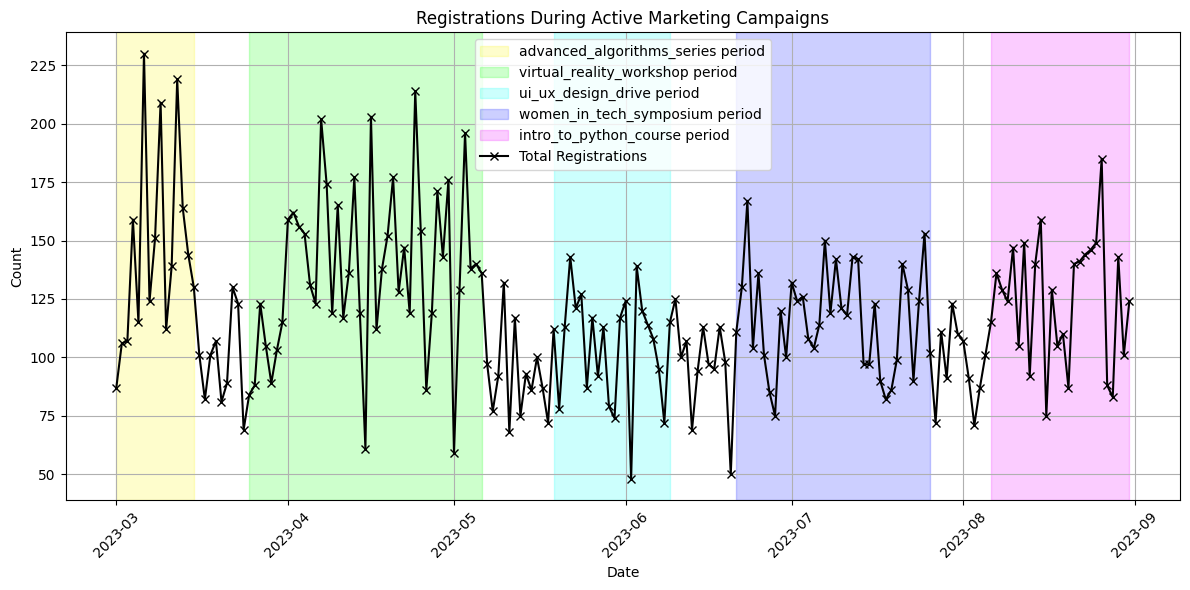

  year_month  conversion
0    2023-03   54.376344
1    2023-04   56.122222
2    2023-05   55.752688
3    2023-06   52.511111
4    2023-07   46.225806
5    2023-08   52.172043


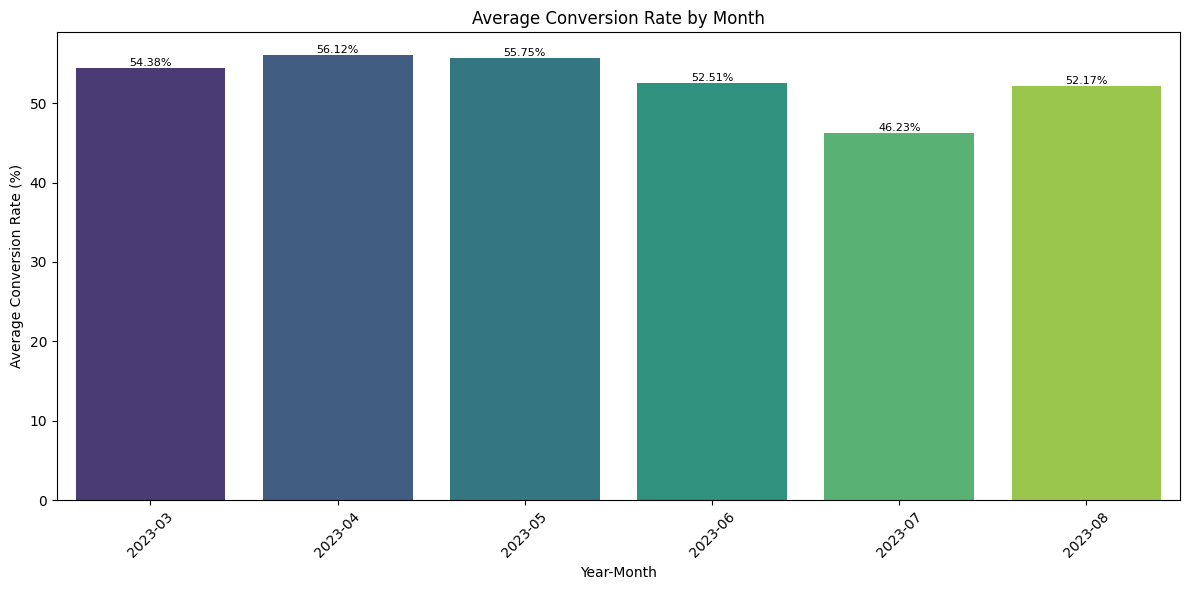

In [7]:
"""Подключение библиотек."""
import os
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv


load_dotenv()


class Api:
    """Объект взаимодействия с API."""

    def __init__(self):
        """Инициализация атрибутов класса."""

        self.base_url = os.getenv('API_URL', 'https://data-charts-api.hexlet.app')
        self.registrations_url = self.base_url + "/registrations"
        self.visits_url = self.base_url + "/visits"
    
    def get_data(self, url, params):
        """Запрос данных."""

        try:
            response = requests.get(url=url, params=params)
            if response.status_code == 200:
                return response.json()
            return None
        except Exception as request_error:
            raise Exception(request_error)


class Metrics:
    def __init__(self, visits_data, registrations_data):
        self.visits_df = pd.DataFrame(visits_data)
        self.registrations_df = pd.DataFrame(registrations_data)

    def get_registrations_conversion(self):
        self.visits_df['datetime'] = pd.to_datetime(self.visits_df['datetime'])
        self.registrations_df['datetime'] = pd.to_datetime(self.registrations_df['datetime'])
        self.visits_df = self.visits_df[self.visits_df['platform'] != 'bot']
        self.visits_df = self.visits_df.sort_values(by='datetime').drop_duplicates(subset='visit_id', keep='last')
        visits_agg = (self.visits_df.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).size().reset_index(name='visits'))
        registrations_agg = (self.registrations_df.groupby([pd.Grouper(key='datetime', freq='D'), 'platform']).size().reset_index(name='registrations'))
        merged_df = visits_agg.merge(registrations_agg,on=['datetime', 'platform'],how='outer').fillna(0)
        merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']).fillna(0).round(2) * 100
        merged_df.rename(columns={'datetime': 'date_group'}, inplace=True)
        merged_df.sort_values(by='date_group', inplace=True)
        merged_df.to_json('conversion.json', orient='records', indent=4)
        return merged_df
    
    """Добавляем рекламы."""

    def aggregate_ads_data(self, ads_csv_path):
        combined_data = pd.read_csv(ads_csv_path, parse_dates=['date'])
        combined_data['date_group'] = combined_data['date'].dt.date
        ads_aggregated = combined_data.groupby(['date_group', 'utm_campaign'], as_index=False)['cost'].sum()
        self.visits_df['date_group'] = self.visits_df['datetime'].dt.date
        self.registrations_df['date_group'] = self.registrations_df['datetime'].dt.date
        visits_aggregated = self.visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')
        registrations_aggregated = self.registrations_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
        combined_data = pd.merge(visits_aggregated, registrations_aggregated, on=['date_group', 'platform'],how='outer').fillna(0)
        combined_data = pd.merge(combined_data, ads_aggregated, on='date_group', how='left')
        combined_data['cost'] = combined_data['cost'].fillna(0)
        combined_data['utm_campaign'] = combined_data['utm_campaign'].fillna('none')
        conversion_data = self.get_registrations_conversion()
        conversion_data['date_group'] = conversion_data['date_group'].dt.date
        combined_data = pd.merge(combined_data, conversion_data[['date_group', 'platform', 'conversion']], on=['date_group', 'platform'], how='left')
        combined_data.sort_values('date_group', inplace=True)
        combined_data.to_json('ads.json', orient='records', date_format='iso', indent=4)
        return combined_data
    
    """Визуализация."""
    
    def visualize_data(self, combined_data):
        charts_dir = './charts'
        os.makedirs(charts_dir, exist_ok=True)
        combined_data['date_group'] = pd.to_datetime(combined_data['date_group'])
        
        # Фильтрация данных по датам
        filtered_data = combined_data[
            (combined_data['date_group'] >= pd.to_datetime('2023-03-01')) &
            (combined_data["date_group"] <= pd.to_datetime('2023-04-30'))
        ]

        # 1. Итоговые визиты
        plt.figure(figsize=(12, 6))
        total_visits = filtered_data.groupby('date_group')['visits'].sum().reset_index()
        sns.barplot(data=total_visits, x='date_group', y='visits', color='lightblue')
        plt.title('Total Visits (Filtered: 2023-03-01 to 2023-04-30)')
        plt.xlabel('Date')
        plt.ylabel('Visits')
        plt.xticks(rotation=45)
        for index, row in total_visits.iterrows():
            plt.text(index, row['visits'], row['visits'], ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.savefig('./charts/total_visits_filtered.png')
        plt.show()

        # 2. Итоговые визиты по платформам
        plt.figure(figsize=(14, 7))
        platform_visits = filtered_data.groupby(['date_group', 'platform'])['visits'].sum().unstack().fillna(0)
        platform_visits.index = platform_visits.index.date
        platform_visits.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Visits by Platform (Stacked)')
        plt.xlabel('Date')
        plt.ylabel('Visits')
        plt.xticks(rotation=45)
        for index, row in total_visits.iterrows():
            plt.text(index, row['visits'], row['visits'], ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'visits_by_platform.png'))
        plt.show()
            
        # 3. Итоговые регистрации
        plt.figure(figsize=(12, 6))
        total_registrations = filtered_data.groupby('date_group')['registrations'].sum().reset_index()
        sns.barplot(data=total_registrations, x='date_group', y='registrations', color='lightcoral')
        plt.title('Total Registrations (Filtered: 2023-03-01 to 2023-04-30)')
        plt.xlabel('Date')
        plt.ylabel('Registrations')
        plt.xticks(rotation=45)
        for index, row in total_registrations.iterrows():
            plt.text(index, row['registrations'], int(row['registrations']), ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'total_registrations_filtered.png'))
        plt.show()
        
        # 4. Регистрации по платформам
        plt.figure(figsize=(14, 7))
        platform_registrations = filtered_data.groupby(['date_group', 'platform'])['registrations'].sum().unstack().fillna(0)
        platform_registrations.index = platform_registrations.index.date
        platform_registrations.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Weekly Registrations by Platform (Stacked)')
        plt.xlabel('Date')
        plt.ylabel('Registrations')
        plt.xticks(rotation=45)
        for index, row in total_registrations.iterrows():
            plt.text(index, row['registrations'], int(row['registrations']), ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'registrations_by_platform.png'))
        plt.show()

        # 5. Конверсия по платформам
        # Филтрация по каждой платформе
        android_df = filtered_data[filtered_data['platform'] == 'android']
        android_df.loc[:, 'conversion'] = android_df['conversion']

        ios_df = filtered_data[filtered_data['platform'] == 'ios']
        ios_df.loc[:, 'conversion'] = ios_df['conversion']

        web_df = filtered_data[filtered_data['platform'] == 'web']
        web_df.loc[:, 'conversion'] = web_df['conversion']

        #android
        plt.figure(figsize=(10, 5))
        plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='yellow', label='android')
        for i, txt in enumerate(android_df['conversion']):
            plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]), 
                        textcoords='offset points', xytext=(0,10), ha='center')
        plt.title('Conversion android')
        plt.xlabel('Date')
        plt.ylabel('Conversion (%)')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'conversion_android.png'))
        plt.show()

        #ios
        plt.figure(figsize=(10, 5))
        plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='purple', label='ios')
        for i, txt in enumerate(ios_df['conversion']):
            plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]), 
                        textcoords='offset points', xytext=(0,10), ha='center')
        plt.title('Conversion ios')
        plt.xlabel('Date')
        plt.ylabel('Conversion (%)')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'conversion_ios.png'))
        plt.show()

        #web
        plt.figure(figsize=(10, 5))
        plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='green', label='web')
        for i, txt in enumerate(web_df['conversion']):
            plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.title('Conversion web')
        plt.xlabel('Date')
        plt.ylabel('Conversion (%)')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'conversion_web.png'))
        plt.show()

        # 6. Стоимости реклам
        plt.figure(figsize=(12, 5))
        filtered_df_costs = filtered_data.groupby('date_group')['cost'].sum().reset_index()
        plt.plot(filtered_df_costs['date_group'], filtered_df_costs['cost'], marker='o', linestyle='-', color='darkred', label='Cost')
        for i, txt in enumerate(filtered_df_costs['cost']):
            plt.annotate(f'{txt:.0f} RUB', (filtered_df_costs['date_group'].iloc[i], filtered_df_costs['cost'].iloc[i]), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        plt.title('Aggregated Ad Campaign Costs (by day)')
        plt.xlabel('Date')
        plt.ylabel('Cost (RUB)')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'aggregated_ad_campaign_costs.png'))
        plt.show()

        # 7. Визиты за весь период с цветовым выделением рекламной кампании
        plt.figure(figsize=(12, 6))
        filtered_campaigns = combined_data[~combined_data['utm_campaign'].isin(['none', None])]
        unique_campaigns = filtered_campaigns['utm_campaign'].unique()
        colors = sns.color_palette('hsv', len(unique_campaigns))
        for idx, campaign in enumerate(unique_campaigns):
            campaign_data = filtered_campaigns[filtered_campaigns['utm_campaign'] == campaign]
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(start_date, end_date, color=colors[idx], alpha=0.2, label=f'{campaign} period')
        total_visits = combined_data.groupby('date_group')['visits'].sum().reset_index()
        plt.plot(total_visits['date_group'], total_visits['visits'], marker='o', color='black', label='Total Visits')
        plt.title('Visits During Active Marketing Campaigns')
        plt.xlabel('Date')
        plt.ylabel('Visits')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'campaign_visits.png'))
        plt.show()

        # 8. Регистрации за весь период с цветовым выделением рекламной кампании
        plt.figure(figsize=(12, 6))
        filtered_campaigns = combined_data[~combined_data['utm_campaign'].isin(['none', None])]
        campaigns = filtered_campaigns.groupby(['date_group', 'utm_campaign']).sum().reset_index()
        unique_campaigns = campaigns['utm_campaign'].unique()
        colors = sns.color_palette('hsv', len(unique_campaigns))
        for idx, campaign in enumerate(unique_campaigns):
            campaign_data = filtered_campaigns[filtered_campaigns['utm_campaign'] == campaign]
            start_date = campaign_data['date_group'].min()
            end_date = campaign_data['date_group'].max()
            plt.axvspan(start_date, end_date, color=colors[idx], alpha=0.2, label=f'{campaign} period')
        total_registrations = combined_data.groupby('date_group')['registrations'].sum().reset_index()
        plt.plot(total_registrations['date_group'], total_registrations['registrations'], marker='x', color='black', label='Total Registrations')
        plt.title('Registrations During Active Marketing Campaigns')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'campaign_registrations.png'))
        plt.show()

        # 9. Средняя конверсия
        # Преобразование двнных для визуализации средней конверсии по месяцам
        combined_data['date_group'] = pd.to_datetime(combined_data['date_group'])
        combined_data['year_month'] = combined_data['date_group'].dt.to_period('M')
        monthly_avg_conversion = combined_data.groupby('year_month')['conversion'].mean().reset_index()
        monthly_avg_conversion['conversion'] = monthly_avg_conversion['conversion']
        print(monthly_avg_conversion)

        # Построение графика 
        plt.figure(figsize=(12, 6))
        sns.barplot(data=monthly_avg_conversion, x='year_month', y='conversion', hue='year_month', palette='viridis')
        plt.title('Average Conversion Rate by Month')
        plt.xlabel('Year-Month')
        plt.ylabel('Average Conversion Rate (%)')
        plt.xticks(rotation=45)
        for index, row in monthly_avg_conversion.iterrows():
            plt.text(index, row['conversion'], f'{row["conversion"]:.2f}%', 
                    ha='center', va='bottom', fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(charts_dir, 'average_conversion_by_month.png'))
        plt.show()


    """Запуск логики."""

def main():
    try:
        api = Api()
        start_date = os.getenv('DATE_BEGIN', '2023-03-01')
        end_date = os.getenv('DATE_END', '2023-09-01')
        params = {'begin': start_date,
                  'end': end_date}
        print('url', api.visits_url)
        visits_data = api.get_data(url=api.visits_url, params=params)
        registrations_data = api.get_data(url=api.registrations_url, params=params)
        registrations_dataframe = pd.DataFrame(registrations_data)
        visits_dataframe = pd.DataFrame(visits_data)
        print('cols', registrations_dataframe.columns.to_list())
        reg_metrics = Metrics(visits_data=visits_dataframe, registrations_data=registrations_dataframe)
        conversion = reg_metrics.get_registrations_conversion()
        print(conversion)
        ads_csv_path = "./ads.csv"
        combined_data = reg_metrics.aggregate_ads_data(ads_csv_path)
        print(combined_data)
        reg_metrics.visualize_data(combined_data)
    except Exception as main_error:
        print(f'Error: {main_error}')
        raise Exception(main_error)

if __name__ == '__main__':
    try:
        main()
    except Exception as error:
        raise Exception(error)